In [100]:
#Simple nu-O event generator for 10s-of-MeV neutrinos
#Follows approach taken by NEWTON
#
#Steps:
# Supply total xs (different choices), interpolate
# Supply partial xs, fit coefficients, interpolate
# Specify neutrino flux, fold with XS, sample
# Choose excitation
# Estimate lepton energy, sample direction
# Calculate lepton energy direction, nuclear recoil
# Draw from pre-computed TALYS de-excitation files to generate events
# Write output in ascii format
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
import utils
import sys

#################
##CONFIGURATION##
#################
interpolationStep_MeV = 0.01 #Interpolate digitized xs plots with this precision
maxEnergy_MeV = 53
energies_MeV_interp = np.arange(0,maxEnergy_MeV,interpolationStep_MeV)
#Interpolate angles over this grid
angles_deg_interp = np.arange(0,180,1)

#Total xs, CSV of format Energy point [MeV], cross section [cm2]
#First point should always be 15.4,0.0 for proper interpolations
total_xs_fname = "data/total_xs/Haxton1987_NEWTON.csv"

#Partial cross sections from the nakazato paper. Format is
#Threshold [MeV],J, [1=-,0=+], xs@20 MeV [cm2], xs@40 MeV [cm2], xs@60 MeV [cm2]
partial_xs_fname = "data/partial_xs/Nakazato2018.csv"

#Lepton angular distribution. Of format
#Energy [MeV], xs@15 deg. [cm2], Energy [MeV], xs@30 deg., ..., xs@165 deg [cm2]
muDAR_lepton_angle_fname = "data/lepton_angle/Haxton1987_muDAR.csv"
SN_lepton_angle_fname = ""

#From NucDeEx
#Filenames of format: Ex_00.250_ldmodel2_parity1.root
#containing tree 
deexcitation_folder = "data/nucdeex/"
if not deexcitation_folder.endswith("/"):
    deexcitation_folder+="/"

outputFormat = "ascii" #root, ascii
nps = 50000
neutrino_direction = [0,0,1]

##Plot settings##
#################
mpl.rcParams['axes.labelsize'] = 16      # x/y label font size
mpl.rcParams['xtick.labelsize'] = 14     # x tick labels
mpl.rcParams['ytick.labelsize'] = 14     # y tick labels
mpl.rcParams['axes.titlesize'] = 16      # title, if used

#######################
##Calculate threshold##
#######################
#(160 + 8 electrons) + nu_e -> (16F + 8 electrons) + 1 electron 
threshold = (utils.atomic_mass_16F_amu-utils.atomic_mass_16O_amu)*utils.amu_to_MeV
print(f"Threshold of 16O CC process is {threshold:.3f} MeV")


Threshold of 16O CC process is 15.412 MeV


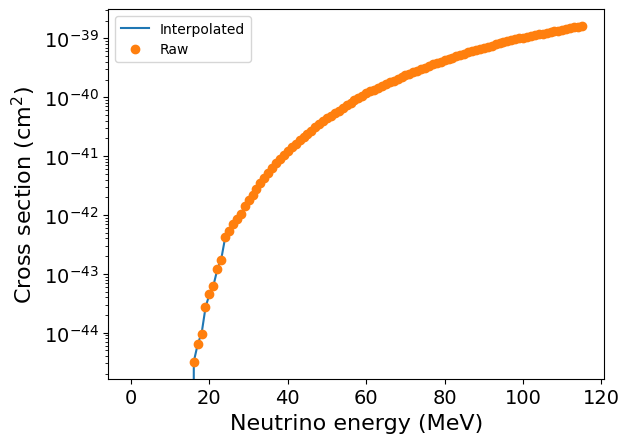

In [101]:
#################
##Load total XS##
#################
energies_MeV_raw,xs_cm2_raw = utils.loadCrossSectionCSV(total_xs_fname)

#Log-linear inteerpolation
with np.errstate(divide='ignore', invalid='ignore'):
    logxs_cm2_raw = np.log10(xs_cm2_raw) #Suppress errors, xs with values equal to zero replaced with -np.inf
logxs_interp = np.interp(energies_MeV_interp, energies_MeV_raw, logxs_cm2_raw,left=-np.inf,right=logxs_cm2_raw[-1])
xs_cm2_interp = np.power(10,logxs_interp)

#Linear interpolation
#xs_cm2_interp = np.interp(energies_MeV_interp,energies_MeV_raw,xs_cm2_raw,left=0,right=xs_cm2_raw[-1])

########
##Plot##
########
plt.plot(energies_MeV_interp,xs_cm2_interp,label="Interpolated")
plt.plot(energies_MeV_raw,xs_cm2_raw,ls="",marker="o",label="Raw")
plt.legend()
plt.xlabel("Neutrino energy (MeV)")
plt.ylabel("Cross section (cm$^2$)")
plt.yscale("log")


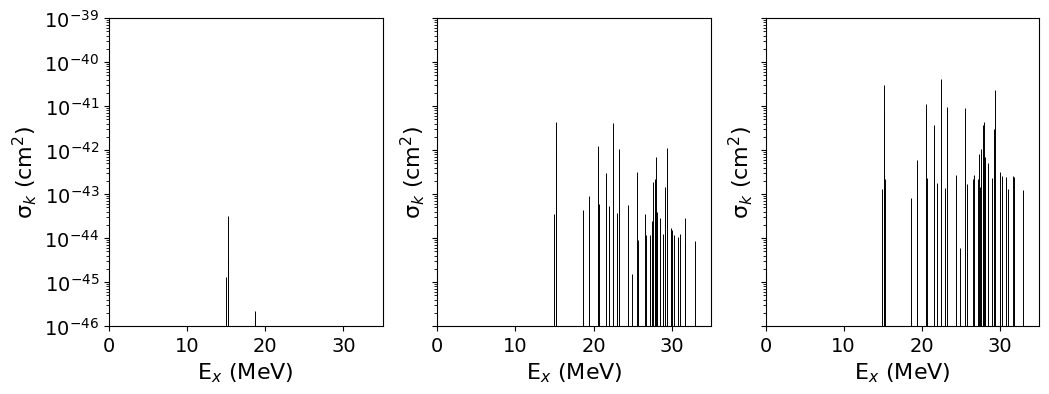

,Excited level [MeV],J,Parity,xs@20 MeV [cm2],xs@40 MeV [cm2],xs@60 MeV [cm2]
0,14.91,0,-,1.28e-45,3.54e-44,1.32e-43
1,15.16,1,-,3.10e-45,9.96e-43,6.81e-42
2,15.21,2,-,3.16e-44,4.38e-42,3.05e-41
3,15.25,3,-,1.00e-46,3.80e-45,2.25e-43
4,18.67,1,+,2.15e-46,4.37e-44,8.03e-44
5,19.42,2,-,1.00e-47,9.18e-44,5.82e-43
6,19.43,1,+,1.00e-47,3.22e-44,8.65e-44
7,20.57,1,-,0.00e+00,1.22e-42,1.09e-41
8,20.69,1,+,0.00e+00,5.99e-44,2.35e-43
9,21.62,2,-,0.00e+00,3.04e-43,3.70e-42


In [102]:
#Load [partial cross section data]
excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV = utils.loadNazakatoPartialXSData(partial_xs_fname)

#Make 3 plots of xs vs. excitation energy 
fig,ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

#Keep only non-zero cross sections for plot
mask = excitedXS_20MeV > 0
ax[0].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_20MeV[mask],color="k",lw=0.7)
mask = excitedXS_40MeV > 0
ax[1].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_40MeV[mask],color="k",lw=0.7)
mask = excitedXS_60MeV > 0
ax[2].vlines(excitedLevels_MeV[mask], 1e-46, excitedXS_60MeV[mask],color="k",lw=0.7)

plt.yscale("log")
ax[0].set_xlim(0,35)
ax[0].set_xlabel("E$_x$ (MeV)")
ax[0].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[0].set_ylim(1e-46,1e-39)

ax[1].set_xlim(0,35)
ax[1].set_xlabel("E$_x$ (MeV)")
ax[1].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[1].set_ylim(1e-46,1e-39)

ax[2].set_xlim(0,35)
ax[2].set_xlabel("E$_x$ (MeV)")
ax[2].set_ylabel(chr(963)+"$_k$ (cm$^2$)")
ax[2].set_ylim(1e-46,1e-39)
plt.show()


df = pd.DataFrame({
    "Excited level [MeV]": excitedLevels_MeV,
    "J": excitedLevels_J,
    "Parity": excitedLevels_parity,
    "xs@20 MeV [cm2]": excitedXS_20MeV,
    "xs@40 MeV [cm2]": excitedXS_40MeV,
    "xs@60 MeV [cm2]": excitedXS_60MeV,
})

# Create the Styler object
formatted_df = df.style.format({
    "Excited level [MeV]": "{:.2f}",
    "J": "{}",
    "Parity": "{}",
    "xs@20 MeV [cm2]": "{:.2e}",
    "xs@40 MeV [cm2]": "{:.2e}",
    "xs@60 MeV [cm2]": "{:.2e}"
}).set_properties(**{
    'text-align': 'center'
})

#Center the column headers
formatted_df.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')])
])

# Display the styled DataFrame
formatted_df

In [103]:
#Functionalize the partial cross sections
c1s,c2s,c3s = utils.solveNakazatoCoeffs(excitedLevels_MeV,excitedXS_20MeV,excitedXS_40MeV,excitedXS_60MeV)

df = pd.DataFrame({
    "Excited level [MeV]": excitedLevels_MeV,
    "a": c1s,
    "b": c2s,
    "c": c3s,
})

# Create the Styler object
formatted_df = df.style.format({
    "Excited level [MeV]": "{:.2f}",
    "a": "{:.4f}",
    "b": "{:.4f}",
    "c": "{:.4f}"
}).set_properties(**{
    'text-align': 'center'
})

# Center the column headers
formatted_df.set_table_styles([
    dict(selector='th', props=[('text-align', 'center')])
])

formatted_df
      


,Excited level [MeV],a,b,c
0,14.91,-42.5674,3.6692,1.0302
1,15.16,-40.7141,5.0034,0.6298
2,15.21,-40.0334,5.3599,1.5232
3,15.25,-41.7075,10.0983,0.0000
4,18.67,-42.9389,0.9266,-0.6685
5,19.42,-41.6232,3.7082,0.0000
6,19.43,-42.7354,1.9831,0.0000
7,20.57,-40.1971,4.1432,0.0000
8,20.69,-42.1488,2.5700,0.0000
9,21.62,-40.5244,4.4735,0.0000


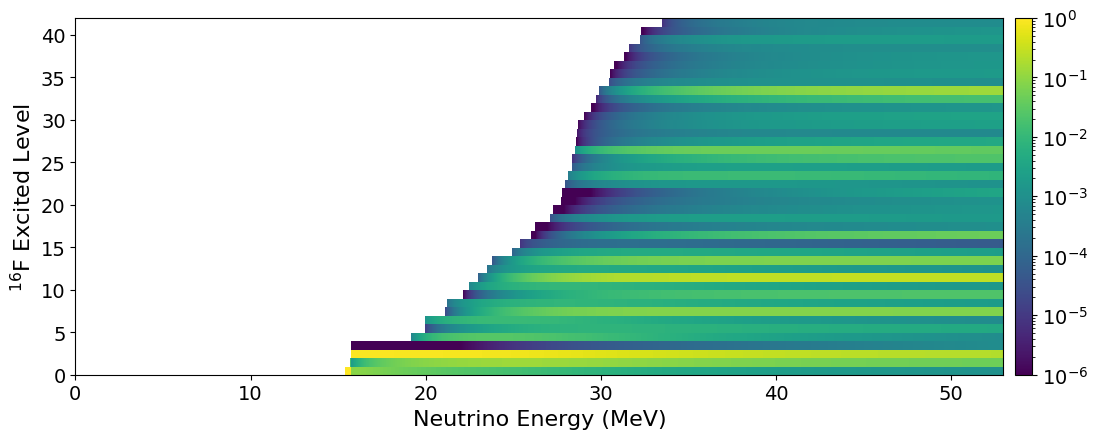

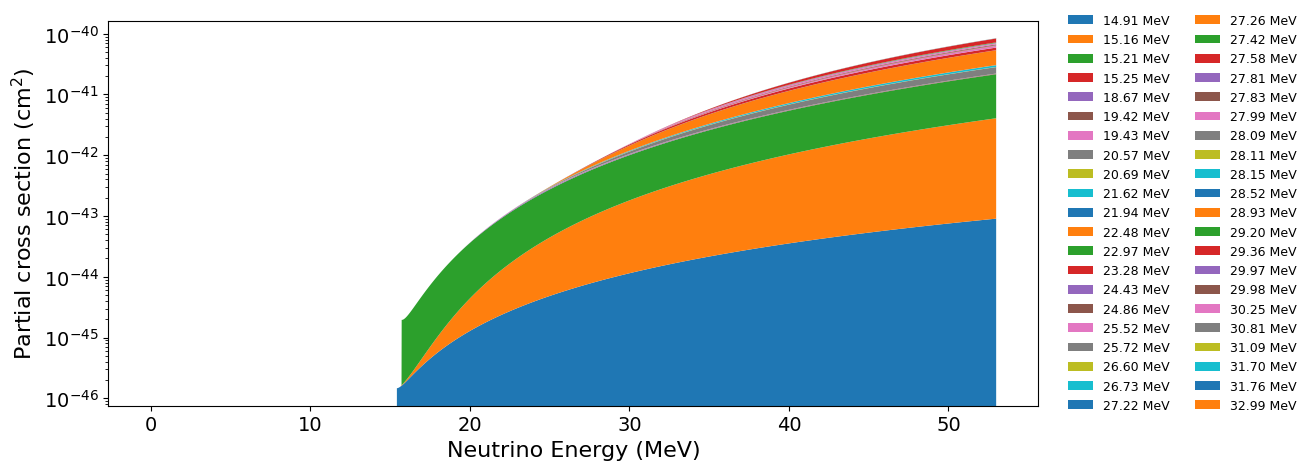

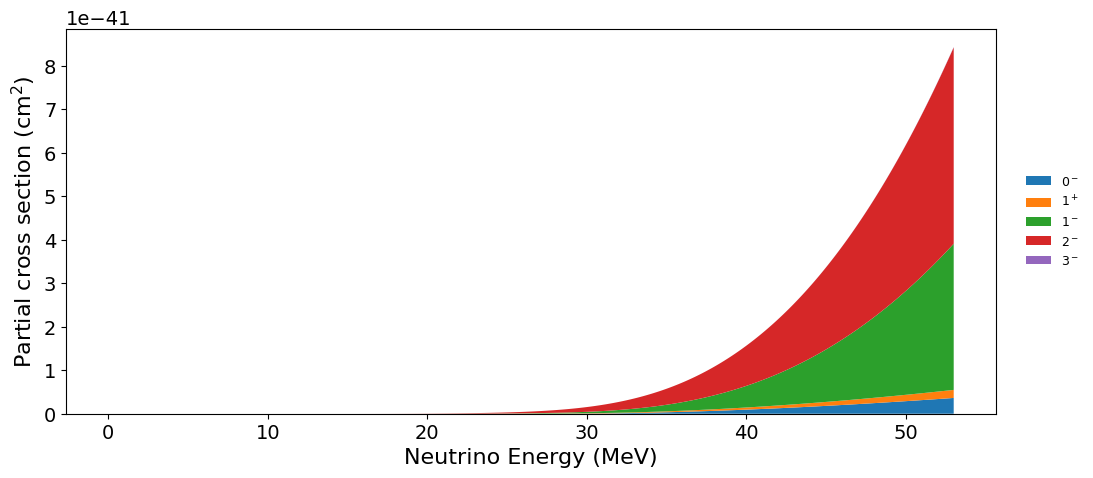

In [104]:
#Calculate partial cross sections on our grid
partial_xs = utils.calcNakazatoPartialXS(excitedLevels_MeV,energies_MeV_interp,c1s,c2s,c3s)

Z = np.vstack([np.asarray(xs) for xs in partial_xs])
#Convert to probabilities
colsum = Z.sum(axis=0)                                
excitation_probs = np.zeros_like(Z, dtype=float)
nonzero_mask = colsum > 0
excitation_probs[:, nonzero_mask] = Z[:, nonzero_mask] / colsum[nonzero_mask]

#############################
##Compare with Baran's plot##
#############################

# Plot: y-axis is uniform "level index" bins; labels show actual excited levels (optional)
fig, ax = plt.subplots(figsize=(12, 4.5))

im = ax.imshow(
    excitation_probs,
    origin="lower",
    aspect="auto",
    interpolation="nearest",
    norm=LogNorm(vmin=1e-6, vmax=1.0),
    extent=[energies_MeV_interp[0],
            energies_MeV_interp[-1],
            0,
            excitation_probs.shape[0]]
)

ax.set_xlabel("Neutrino Energy (MeV)")
ax.set_ylabel("$^{16}$F Excited Level")
cbar = plt.colorbar(im, ax=ax, pad=0.01)
plt.tight_layout()

#####################
##Plot exclusive xs##
#####################
fig2,ax2 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in partial_xs])   # (nlev, nE)

labels = [f"{excitedLevels_MeV[i]:.2f} MeV" for i in range(xs_stack.shape[0])]

ax2.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax2.set_xlabel("Neutrino Energy (MeV)")
ax2.set_ylabel(r"Partial cross section (cm$^2$)")
ax2.set_yscale("log")

ax2.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    ncol=2,                      # number of columns (adjust as needed)
    fontsize=9,
    frameon=False
)

##################
##Multipole plot##
##################
JPis = np.array([f"{J}$^{p}$"
                 for J, p in zip(excitedLevels_J, excitedLevels_parity)])
multipoles = np.unique(JPis)
multipole_xs=[np.zeros_like(energies_MeV_interp) for _ in multipoles]
for mi, multipole in enumerate(multipoles):
    indices = np.where(JPis == multipole)[0]
    for idx in indices:
        multipole_xs[mi] += partial_xs[idx]    # <-- add into the right bucket


fig3,ax3 = plt.subplots(figsize=(12,5))
xs_stack = np.vstack([np.asarray(xs) for xs in multipole_xs])   # (nMultipoles, nE)
labels = list(multipoles)

ax3.stackplot(energies_MeV_interp, xs_stack, labels=labels)
ax3.set_xlabel("Neutrino Energy (MeV)")
ax3.set_ylabel(f"Partial cross section (cm$^2$)")
ax3.set_yscale("linear")

ax3.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),  # push legend to the right
    fontsize=9,
    frameon=False
)

plt.show()

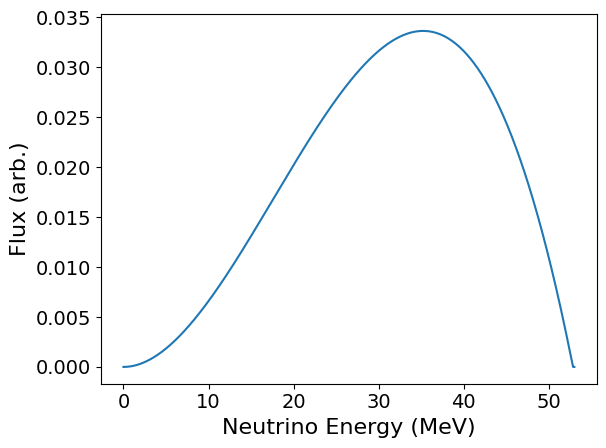

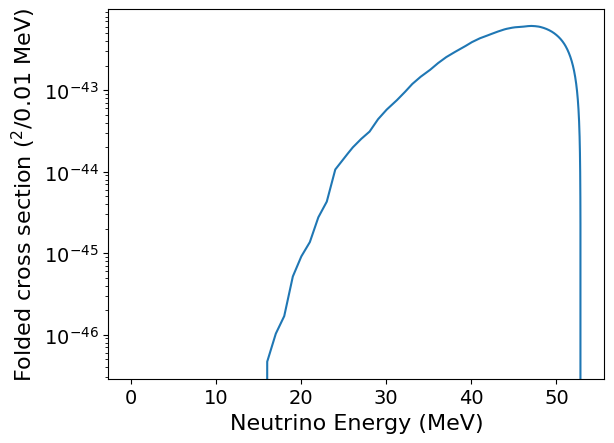

8.256963225502652e-42


In [105]:
#SNS neutrino spectrum
dar_spectrum = 96*np.power(energies_MeV_interp,2) * np.power(utils.mass_mu_MeV,-4)  * (utils.mass_mu_MeV - 2*energies_MeV_interp)
dar_spectrum = np.where(dar_spectrum > 0, dar_spectrum, 0) #Function turns negative at high energies, replace with zeros

#TODO: Supernova spectrum

#Calculate folded cross section
folded_spectrum = np.multiply(xs_cm2_interp,dar_spectrum)
#Calculate flux-averaged spectrum

num = np.trapezoid(xs_cm2_interp * dar_spectrum, energies_MeV_interp)
den = np.trapezoid(dar_spectrum, energies_MeV_interp)
flux_averaged_xs = num / den

flux_averaged_xs_naturalunits = flux_averaged_xs/utils.hbar_c_squared
# Normalize
neutrino_energy_probs = folded_spectrum / folded_spectrum.sum()


########
##PLOT##
########
fig,ax=plt.subplots()
plt.plot(energies_MeV_interp,dar_spectrum)
ax.set_xlabel("Neutrino Energy (MeV)")
ax.set_ylabel(f"Flux (arb.)")

fig2,ax2=plt.subplots()
plt.plot(energies_MeV_interp,folded_spectrum)
plt.yscale("log")
ax2.set_xlabel("Neutrino Energy (MeV)")
ax2.set_ylabel(f"Folded cross section ($^2$/{interpolationStep_MeV} MeV)")


plt.show()
print(flux_averaged_xs)

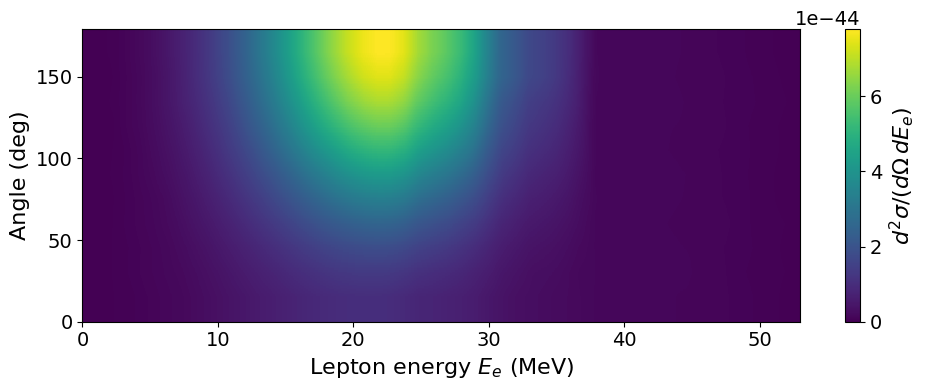

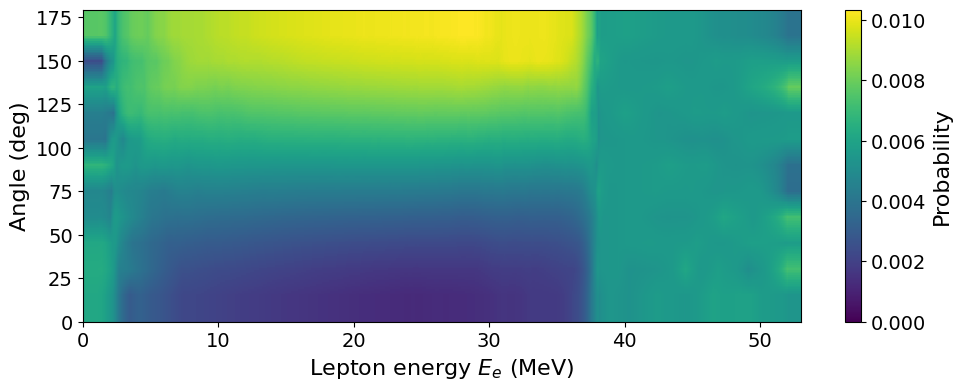

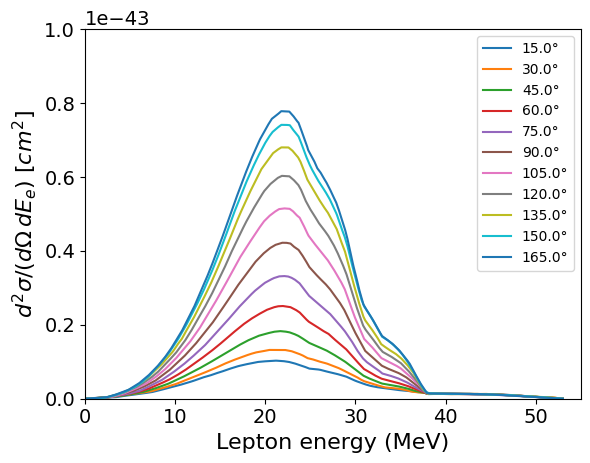

In [ ]:
#Load up lepton angular distributions
angles_raw,lepton_energies_raw,haxton_xs_raw = utils.loadHaxtonAngles(muDAR_lepton_angle_fname)

#Intepolate the above plot over our energy/angle grid
angle_energy_xs_cm2 = utils.interpolateHaxtonAngles(angles_raw,angles_deg_interp,lepton_energies_raw,energies_MeV_interp,haxton_xs_raw)

theta_rad_interp = np.deg2rad(angles_deg_interp)
sin_weights = np.sin(theta_rad_interp)
weighted_xs = angle_energy_xs_cm2 * sin_weights[:, np.newaxis]

#Create probabilitiy distributions, normalized per lepton energy
lepton_angle_probs = np.zeros_like(angle_energy_xs_cm2)
colsum = angle_energy_xs_cm2.sum(axis=0)
mask = colsum > 0
lepton_angle_probs[:, mask] = angle_energy_xs_cm2[:, mask] / colsum[mask]

########
##Plot##
########
fig, ax = plt.subplots(figsize=(10,4))
im = ax.imshow(
    angle_energy_xs_cm2,
    origin="lower",
    aspect="auto",
    extent=[energies_MeV_interp[0], energies_MeV_interp[-1],
            angles_deg_interp[0], angles_deg_interp[-1]],
    interpolation="None"
)

ax.set_xlabel("Lepton energy $E_e$ (MeV)")
ax.set_ylabel("Angle (deg)")
cb = fig.colorbar(im, ax=ax)
cb.set_label(f"$d^2\sigma/(d\Omega\, dE_e)$")
fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=(10,4))
im2 = ax2.imshow(
    lepton_angle_probs,
    origin="lower",
    aspect="auto",
    extent=[energies_MeV_interp[0], energies_MeV_interp[-1],
            angles_deg_interp[0], angles_deg_interp[-1]],
    interpolation="None"
)
ax2.set_xlabel("Lepton energy $E_e$ (MeV)")
ax2.set_ylabel("Angle (deg)")
cb2 = fig2.colorbar(im2, ax=ax2)
cb2.set_label("Probability")
fig2.tight_layout()
plt.show()

#Plot 1D curves
fig3,ax3=plt.subplots()
for angle in angles_raw:
    #Find index of angle in angles_deg_interp
    idx = np.searchsorted(angles_deg_interp, angle)
    #Plot 1D curve
    ax3.plot(energies_MeV_interp, angle_energy_xs_cm2[idx, :], label=f"{angle}°")
ax3.set_ybound(0,10e-44)
ax3.set_xbound(0,55)
plt.xlabel("Lepton energy (MeV)")
plt.ylabel(f"$d^2\sigma/(d\Omega\, dE_e)$ [$cm^2$]")
plt.legend()
plt.show()



In [107]:
#Load de-excitation data
ex_dfs = utils.loadNucDeExData(deexcitation_folder)

In [108]:
#Generate our events in MARLEY format
line=str(flux_averaged_xs_naturalunits)

#Number of initial particles, hardcoded
Ni = 2 #Hardcoded

#Sample neutrino eneries from folded xs times spectrum
sampled_neutrino_energies_MeV = np.random.choice(energies_MeV_interp, size=nps, p=neutrino_energy_probs)

outFile = open("test.o","w")
outFile.write(line)

#For validation
sampled_lepton_energies = []
calculated_lepton_energies = []
sampled_thetas_deg = []

items = [energies_MeV_interp,excitedLevels_MeV,excitedLevels_J,excitedLevels_parity,excitation_probs,ex_dfs,
        angles_deg_interp,lepton_angle_probs,
        neutrino_direction,utils.nuc_mass_16O_MeV,utils.nuc_mass_16F_MeV,
        "16O","16F","ve","electron"]
args = [(Enu, *items) for Enu in sampled_neutrino_energies_MeV]

############
#MAIN LOOP##
############
#Sample our excitation probabilities at the neutrino energy, calculate lepton energy, angle
for inps,Enu in enumerate(sampled_neutrino_energies_MeV):
  if inps%5000==0:
     print(f"On entry {inps}")

  header,inParticles,outParticles = utils.sampleEvent(args[inps])
  for part in outParticles:
     if part["pdg"]==11:
        calculated_lepton_energies.append(part["totalE"]-part["mass"])
  sampled_lepton_energies.append(header["Ee_sampled"])
  sampled_thetas_deg.append(header["theta_deg"])

#Write ascii output 
outFile.close()



On entry 0
On entry 5000
On entry 10000
On entry 15000
On entry 20000
On entry 25000
On entry 30000
On entry 35000
On entry 40000
On entry 45000


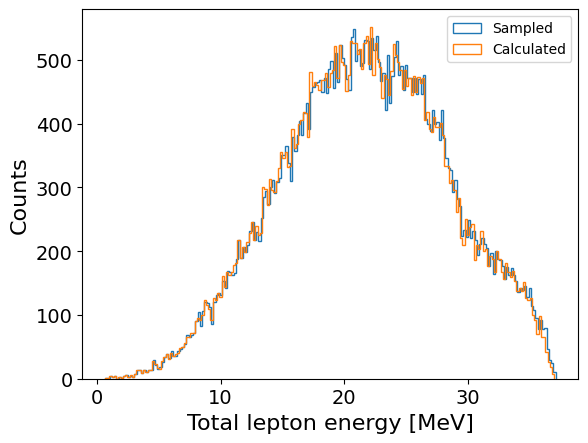

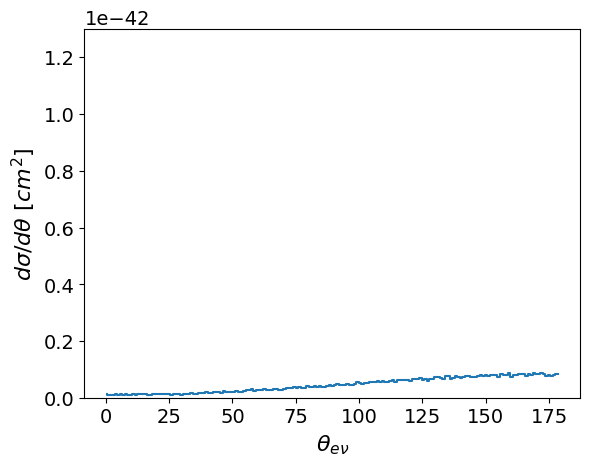

In [127]:
#Validation
fig,ax = plt.subplots()
plt.hist(sampled_lepton_energies,bins=200,histtype='step',label="Sampled")
plt.hist(calculated_lepton_energies,bins=200,histtype='step',label="Calculated")
plt.xlabel("Total lepton energy [MeV]")
plt.ylabel("Counts")
plt.legend()


fig2,ax2 = plt.subplots()
counts,edges = np.histogram(sampled_thetas_deg,bins=180)
bin_widths = np.diff(edges)
centers = 0.5*(edges[:-1] + edges[1:])

dsigma_dtheta = (counts/np.sum(counts)*flux_averaged_xs/bin_widths)

plt.step(centers, dsigma_dtheta)
plt.xlabel("$\\theta_{e\\nu}$")
plt.ylabel(f"$d\sigma/d\\theta$ [$cm^2$]")
plt.ylim(0,13e-43)
plt.show()

